In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import os
cwd = os.getcwd()
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_palette("GnBu_d")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
%matplotlib inline

SAVEDIR = "../plots/tmd-hoppings"
if not os.path.exists(SAVEDIR):
    os.makedirs(SAVEDIR)


# The nanorribon

[]

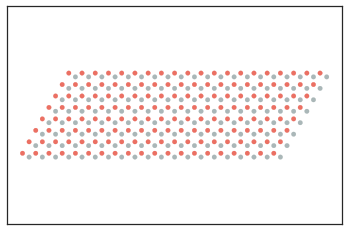

In [2]:
Nx = 20
Ny = 8

a1 = np.arange(Nx)
a2 = np.arange(Ny)
vs = np.zeros((2 * Nx * Ny , 2))
lat = np.zeros((2 * Nx * Ny))
clr = np.chararray((2 * Nx * Ny), itemsize = 10)
alpha = np.zeros((2 * Nx * Ny))
v1 = np.array([1, 0])
v2 = np.array([1 / 2, np.sqrt(3) / 2])
for i in range(Nx):
    for j in range(Ny):
        for k in range(2):
            vs[Nx * Ny * k + Nx * j + i, :] =\
            a1[i] * v1 + a2[j] * v2 + k *\
            np.array([1 / 2,- 1 / ( 2 * np.sqrt(3) )])
            #lat[Nx * Ny * k + Nx * j + i]\
            #=  400 * (nUp[Nx * Ny * k + Nx * j + i]\
            #          - nDown[Nx * Ny * k + Nx * j + i] )
            if k == 0 :
                clr[Nx * j + i] = "#e74c3c"
            if k == 1 :
                clr[Nx * Ny + Nx * j + i] = "#95a5a6"

fig = plt.figure(6)
ax = fig.add_subplot(111)
ax.scatter(vs[:, 0], vs[:, 1], s = 20,\
           c = clr.decode('UTF-8'), alpha=0.8, edgecolors = None)
ax.axis('equal')
ax.set_yticklabels([])
ax.set_xticklabels([])

# The hopping are only between M atoms, say the red ones

## We start by defining the model. Insert the parameters below. Here we choose $\text{Mo}\text{S}_2$ and use GCA data (see Liu2013)

In [3]:
nOrb = 3

#e1 = 1.046
#e2 = 2.104
#t0 = - 0.184
#t1 = 0.401
#t2 = 0.507
#t11 = 0.218
#t12 = 0.338
#t22 = 0.057

e1 = 1.046 / 0.184
e2 = 2.104 / 0.184
t0 = - 1
t1 = 0.401 / 0.184
t2 = 0.507 / 0.184
t11 = 0.218 / 0.184
t12 = 0.338 / 0.184
t22 = 0.057 / 0.184

E0 = np.array([[e1, 0, 0],
               [0, e2, 0],
               [0, 0, e2]])

E1 = np.array([[t0, t1, t2],
               [-t1, t11, t12],
               [t2, -t12, t22]])

E4 = np.array([[t0, -t1, t2],
               [t1, t11, -t12],
               [t2, t12, t22]])

E2 = np.array([[t0, 0.5 * t1 - np.sqrt(3) / 2 * t2, - np.sqrt(3) / 2 * t1 - 0.5 * t2],
               [-0.5 * t1 - np.sqrt(3) / 2 * t2, 0.25 * ( t11 + 3 * t22 ), np.sqrt(3) / 4 * ( t22 - t11 ) - t12],
               [np.sqrt(3) / 2 * t1 - 0.5 * t2, np.sqrt(3) / 4 * ( t22 - t11 ) + t12, ( 3 * t11 + t22) / 4 ]])

E5 = np.array([[t0, - 0.5 * t1 - np.sqrt(3) / 2 * t2, np.sqrt(3) / 2 * t1 - 0.5 * t2],
               [0.5 * t1 - np.sqrt(3) / 2 * t2, 0.25 * ( t11 + 3 * t22 ), np.sqrt(3) / 4 * ( t22 - t11 ) + t12],
               [-np.sqrt(3) / 2 * t1 - 0.5 * t2, np.sqrt(3) / 4 * ( t22 - t11 ) - t12, ( 3 * t11 + t22) / 4 ]])

E3 = np.array([[t0, - 0.5 * t1 + np.sqrt(3) / 2 * t2, -np.sqrt(3) / 2 * t1 - 0.5 * t2],
               [0.5 * t1 + np.sqrt(3) / 2 * t2, 0.25 * ( t11 + 3 * t22 ), -np.sqrt(3) / 4 * ( t22 - t11 ) + t12],
               [np.sqrt(3) / 2 * t1 - 0.5 * t2, -np.sqrt(3) / 4 * ( t22 - t11 ) - t12, ( 3 * t11 + t22) / 4 ]])

E6 = np.array([[t0, 0.5 * t1 + np.sqrt(3) / 2 * t2, np.sqrt(3) / 2 * t1 - 0.5 * t2],
               [-0.5 * t1 + np.sqrt(3) / 2 * t2, 0.25 * ( t11 + 3 * t22 ), -np.sqrt(3) / 4 * ( t22 - t11 ) - t12],
               [-np.sqrt(3) / 2 * t1 - 0.5 * t2, -np.sqrt(3) / 4 * ( t22 - t11 ) + t12, ( 3 * t11 + t22) / 4 ]])

hoppings = np.array([E0, E1, E2, E3, E4, E5, E6])

## Now we figure out how to find nearest neighbors on a triangular lattice with nanorribon boundary conditions

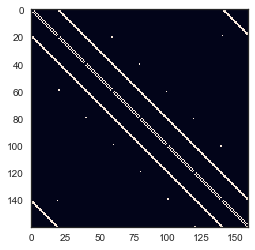

In [4]:
def iTriang(x, y, Nx, Ny):
    return Nx * y + x

def triangular(Nx, Ny):
    T = np.zeros((Nx*Ny, Nx*Ny))
    for x in range(Nx):
        for y in range(Ny):
            T[iTriang(x, y, Nx, Ny), iTriang( (x + 1) % Nx , y, Nx, Ny)] = 1
            T[iTriang( (x + 1) % Nx , y, Nx, Ny), iTriang(x, y, Nx, Ny)] = 1
            if y == 0:
                T[iTriang(x, 0, Nx, Ny), iTriang( x, 1, Nx, Ny)] = 1
                T[iTriang(x, 1, Nx, Ny), iTriang( x, 0, Nx, Ny)] = 1
                if x == 0:
                    T[iTriang(x, 0, Nx, Ny), iTriang( Nx - 1, 1, Nx, Ny)] = 1
                    T[iTriang( Nx - 1, 1, Nx, Ny), iTriang(x, 0, Nx, Ny)] = 1
                else:
                    T[iTriang(x, 0, Nx, Ny), iTriang( x - 1, 1, Nx, Ny)] = 1
                    T[iTriang(x - 1, 1, Nx, Ny), iTriang(x, 0, Nx, Ny)] = 1
                    
            # Periodic
                T[ iTriang(x, 0, Nx, Ny), iTriang( x, Ny - 1, Nx, Ny)] = 1
                T[ iTriang(x, Ny - 1, Nx, Ny), iTriang( x, 0, Nx, Ny)] = 1
                
                T[ iTriang(x, 0, Nx, Ny), iTriang( ( x + 1 ) % Nx, Ny - 1, Nx, Ny)] = 1
                T[ iTriang( ( x + 1 ) % Nx, Ny - 1, Nx, Ny), iTriang(x, 0, Nx, Ny)] = 1
                
            #
            else:
                if y == Ny - 1:
                    T[iTriang(x, Ny - 1 , Nx, Ny), iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny)] = 1
                    T[iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny), iTriang(x, Ny - 1, Nx, Ny)] = 1
                    T[iTriang(x, Ny - 1, Nx, Ny), iTriang( x, Ny - 2, Nx, Ny)] = 1
                    T[iTriang(x, Ny - 2, Nx, Ny), iTriang( x, Ny - 1, Nx, Ny)] = 1
                    
                    # Periodic 
                    T[iTriang(x, Ny - 1, Nx, Ny), iTriang( x, 0, Nx, Ny)] = 1
                    T[iTriang( x, 0, Nx, Ny), iTriang(x, Ny - 1, Nx, Ny)] = 1
                    if x == 0:
                        T[iTriang(x, y, Nx, Ny), iTriang( Nx - 1, 0, Nx, Ny)] = 1
                        T[iTriang( Nx - 1, 0, Nx, Ny),iTriang(x, y, Nx, Ny)] = 1
                    else:
                        T[iTriang(x, y, Nx, Ny), iTriang(x - 1, 0, Nx, Ny)] = 1
                        T[iTriang(x - 1, 0, Nx, Ny), iTriang(x, y, Nx, Ny)] = 1
                    #
                    
                else:
                    T[iTriang(x, y , Nx, Ny), iTriang( (x + 1) % Nx , y - 1, Nx, Ny)] = 1
                    T[iTriang( (x + 1) % Nx , y - 1, Nx, Ny), iTriang(x, y, Nx, Ny)] = 1
                    T[iTriang(x, y, Nx, Ny), iTriang( x, y - 1, Nx, Ny)] = 1
                    T[iTriang(x, y - 1, Nx, Ny), iTriang( x, y, Nx, Ny)] = 1
                    if x == 0:
                        T[iTriang(x, y, Nx, Ny), iTriang( Nx - 1, y + 1, Nx, Ny)] = 1
                        T[iTriang( Nx - 1, y + 1, Nx, Ny), iTriang(x, y, Nx, Ny)] = 1
                    else:
                        T[iTriang(x, y, Nx, Ny), iTriang( x - 1, y + 1, Nx, Ny)] = 1
                        T[iTriang(x - 1, y + 1, Nx, Ny), iTriang(x, y, Nx, Ny)] = 1
    return T

spaceHoppings = triangular(Nx, Ny)
plt.imshow(spaceHoppings, interpolation='nearest')

## Now we need to adapt this function to insert block matrices instead of ones. Fortunately, this is easy on numpy (and on C++ linear algebra library Eigen using .block)

In [5]:
A = np.array([[1, 2, 3],
              [4, 5, 6],
              [7, 8, 9]])

B = np.array([[0, 0],
              [0, 0]])

A

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [6]:
A[0:2, 0:2] = B

In [7]:
A

array([[0, 0, 3],
       [0, 0, 6],
       [7, 8, 9]])

## So all we need to do is building a huge matrix of 3x3 block matrices. Here we add the hoppings needed to turn the ribbon into the periodic system

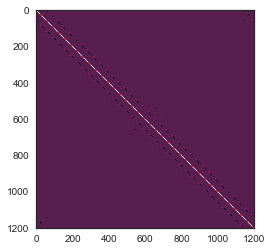

In [8]:
def iTriang(x, y, Nx, Ny):
    return Nx * y + x

def triangular(Nx, Ny, nOrb, hoppings):
    T = np.zeros((nOrb*Nx*Ny, nOrb*Nx*Ny))
    for x in range(Nx):
        for y in range(Ny):
            # Diagonal term
            T[ iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny) + 1) * nOrb,\
              iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny) + 1) * nOrb ]\
            = hoppings[0]
            
            # E1
            T[ iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny) + 1)*nOrb,\
              iTriang( (x + 1) % Nx , y, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y, Nx, Ny) + 1)*nOrb ]\
            = hoppings[1]
            
            # E4
            T[ iTriang( (x + 1) % Nx , y, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y, Nx, Ny) + 1)*nOrb\
              , iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb ] = hoppings[4]
            
            if y == 0:
                T[ iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb,\
                  iTriang( x, 1, Nx, Ny)*nOrb:(iTriang( x, 1, Nx, Ny)+1)*nOrb ]\
                = hoppings[6]
                
                T[ iTriang(x, 1, Nx, Ny)*nOrb:(iTriang(x, 1, Nx, Ny)+1)*nOrb,\
                  iTriang( x, 0, Nx, Ny)*nOrb:(iTriang( x, 0, Nx, Ny)+1)*nOrb ]\
                = hoppings[3]
                
                # Periodic
                T[ iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb,\
                  iTriang( x, Ny - 1, Nx, Ny)*nOrb:(iTriang( x, Ny - 1, Nx, Ny)+1)*nOrb ]\
                = hoppings[3]
                T[ iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb,\
                  iTriang( x, 0, Nx, Ny)*nOrb:(iTriang( x, 0, Nx, Ny)+1)*nOrb ]\
                = hoppings[6]
                
                T[ iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb,\
                  iTriang( ( x + 1 ) % Nx, Ny - 1, Nx, Ny)*nOrb:(iTriang( ( x + 1 ) % Nx, Ny - 1, Nx, Ny)+1)*nOrb ]\
                = hoppings[2]
                T[iTriang( ( x + 1 ) % Nx, Ny - 1, Nx, Ny)*nOrb:(iTriang( ( x + 1 ) % Nx, Ny - 1, Nx, Ny)+1)*nOrb,\
                iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb]\
                = hoppings[5]
                
                #
                if x == 0:
                    T[iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny) + 1)*nOrb,\
                      iTriang( Nx - 1, 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, 1, Nx, Ny) + 1)*nOrb]\
                    = hoppings[5]
                    T[iTriang( Nx - 1, 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, 1, Nx, Ny)+1)*nOrb,\
                      iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb]\
                    = hoppings[2]
                else:
                    T[iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb,\
                      iTriang( x - 1, 1, Nx, Ny)*nOrb:(iTriang( x - 1, 1, Nx, Ny)+1)*nOrb]\
                    = hoppings[5]
                    T[iTriang(x - 1, 1, Nx, Ny)*nOrb:(iTriang(x - 1, 1, Nx, Ny)+1)*nOrb,\
                      iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb]\
                    = hoppings[2]
            else:
                if y == Ny - 1:
                    T[iTriang(x, Ny - 1 , Nx, Ny)*nOrb:(iTriang(x, Ny - 1 , Nx, Ny) + 1)*nOrb,\
                      iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny) + 1)*nOrb]\
                    = hoppings[2]
                    T[iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny)+1)*\
                      nOrb, iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb]\
                    = hoppings[5]
                    T[iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb,\
                      iTriang( x, Ny - 2, Nx, Ny)*nOrb:(iTriang( x, Ny - 2, Nx, Ny)+1)*nOrb]\
                    = hoppings[3]
                    T[iTriang(x, Ny - 2, Nx, Ny)*nOrb:(iTriang(x, Ny - 2, Nx, Ny)+1)*nOrb,\
                      iTriang( x, Ny - 1, Nx, Ny)*nOrb:(iTriang( x, Ny - 1, Nx, Ny)+1)*nOrb]\
                    = hoppings[6]
                    # Periodic 
                    T[iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb,\
                      iTriang( x, 0, Nx, Ny)*nOrb:(iTriang( x, 0, Nx, Ny)+1)*nOrb]\
                    = hoppings[6]
                    T[iTriang( x, 0, Nx, Ny)*nOrb:(iTriang( x, 0, Nx, Ny)+1)*nOrb,\
                      iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb]\
                    = hoppings[3]
                    if x == 0:
                        T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,\
                          iTriang( Nx - 1, 0, Nx, Ny)*nOrb:(iTriang( Nx - 1, 0, Nx, Ny)+1)*nOrb]\
                        = hoppings[5]
                        T[iTriang( Nx - 1, 0, Nx, Ny)*nOrb:(iTriang( Nx - 1, 0, Nx, Ny)+1)*nOrb,\
                          iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]\
                        = hoppings[2]
                    else:
                        T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,\
                          iTriang(x - 1, 0, Nx, Ny)*nOrb:(iTriang(x - 1, 0, Nx, Ny)+1)*nOrb]\
                        = hoppings[5]
                        T[iTriang(x - 1, 0, Nx, Ny)*nOrb:(iTriang(x - 1, 0, Nx, Ny)+1)*nOrb,\
                          iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]\
                        = hoppings[2]
                    #
                else:
                    T[iTriang(x, y , Nx, Ny)*nOrb:(iTriang(x, y , Nx, Ny)+1)*nOrb,\
                      iTriang( (x + 1) % Nx , y - 1, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y - 1, Nx, Ny)+1)*nOrb]\
                    = hoppings[2]
                    T[iTriang( (x + 1) % Nx , y - 1, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y - 1, Nx, Ny)+1)*nOrb,\
                      iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]\
                    = hoppings[5]
                    T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,\
                      iTriang( x, y - 1, Nx, Ny)*nOrb:(iTriang( x, y - 1, Nx, Ny)+1)*nOrb] = hoppings[3]
                    T[iTriang(x, y - 1, Nx, Ny)*nOrb:(iTriang(x, y - 1, Nx, Ny)+1)*nOrb,\
                      iTriang( x, y, Nx, Ny)*nOrb:(iTriang( x, y, Nx, Ny)+1)*nOrb] = hoppings[6]
                    if x == 0:
                        T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,\
                          iTriang( Nx - 1, y + 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, y + 1, Nx, Ny)+1)*nOrb]\
                        = hoppings[5]
                        T[iTriang( Nx - 1, y + 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, y + 1, Nx, Ny)+1)*nOrb,\
                          iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]\
                        = hoppings[2]
                    else:
                        T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,\
                          iTriang(x - 1, y + 1, Nx, Ny)*nOrb:(iTriang(x - 1, y + 1, Nx, Ny)+1)*nOrb]\
                        = hoppings[5]
                        T[iTriang(x - 1, y + 1, Nx, Ny)*nOrb:(iTriang(x - 1, y + 1, Nx, Ny)+1)*nOrb,\
                          iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]\
                        = hoppings[2]
    return T

Nx = 20
Ny = 20

orbitalHoppings = triangular(Nx, Ny, nOrb, hoppings)
plt.imshow(orbitalHoppings, interpolation='nearest')

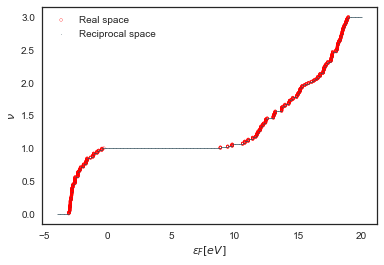

In [14]:
ensMoS2 = la.eigvalsh(orbitalHoppings)
fig = plt.figure(0)
ax = fig.add_subplot(111)

ax.scatter(ensMoS2, np.arange(ensMoS2.size) / ensMoS2.size * 3, label='Real space'\
           , facecolors = 'none', edgecolors = 'r', marker = 'o', s = 8)
plt.xlabel(r'$\varepsilon_F [ eV]$')
plt.ylabel(r'$\nu$')
compareFill = np.loadtxt("filling-E_3orbModel_MoS2_noSOC_Units-t0.csv", delimiter=',')
ax.scatter(compareFill[:, 1], compareFill[:, 0] , s = 0.1, label='Reciprocal space')
lgd = ax.legend(loc=2)
plt.savefig(SAVEDIR + "/fillingVsE.png", dpi = 600, bbox_inches='tight')

In [10]:
ensMoS2[368]

-1.1199134091876259

## Now with nanoribbon Boundary Conditions

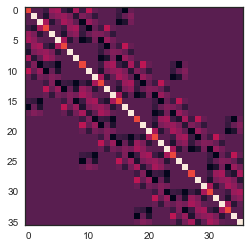

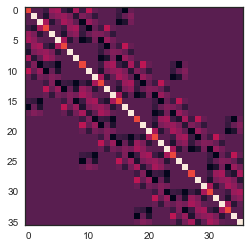

In [16]:
Nx = 3
Ny = 4

def triangularNano(Nx, Ny, nOrb, hoppings):
    T = np.zeros((nOrb*Nx*Ny, nOrb*Nx*Ny))
    for x in range(Nx):
        for y in range(Ny):
            # Diagonal term
            T[ iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny) + 1) * nOrb,\
              iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny) + 1) * nOrb ]\
            = hoppings[0]
            
            # E1
            T[ iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny) + 1)*nOrb,\
              iTriang( (x + 1) % Nx , y, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y, Nx, Ny) + 1)*nOrb ]\
            = hoppings[1]
            
            # E4
            T[ iTriang( (x + 1) % Nx , y, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y, Nx, Ny) + 1)*nOrb\
              , iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb ] = hoppings[4]
            
            if y == 0:
                T[ iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb,\
                  iTriang( x, 1, Nx, Ny)*nOrb:(iTriang( x, 1, Nx, Ny)+1)*nOrb ]\
                = hoppings[6]
                
                T[ iTriang(x, 1, Nx, Ny)*nOrb:(iTriang(x, 1, Nx, Ny)+1)*nOrb,\
                  iTriang( x, 0, Nx, Ny)*nOrb:(iTriang( x, 0, Nx, Ny)+1)*nOrb ]\
                = hoppings[3]
                
                if x == 0:
                    T[iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny) + 1)*nOrb,\
                      iTriang( Nx - 1, 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, 1, Nx, Ny) + 1)*nOrb]\
                    = hoppings[5]
                    T[iTriang( Nx - 1, 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, 1, Nx, Ny)+1)*nOrb,\
                      iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb]\
                    = hoppings[2]
                else:
                    T[iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb,\
                      iTriang( x - 1, 1, Nx, Ny)*nOrb:(iTriang( x - 1, 1, Nx, Ny)+1)*nOrb]\
                    = hoppings[5]
                    T[iTriang(x - 1, 1, Nx, Ny)*nOrb:(iTriang(x - 1, 1, Nx, Ny)+1)*nOrb,\
                      iTriang(x, 0, Nx, Ny)*nOrb:(iTriang(x, 0, Nx, Ny)+1)*nOrb]\
                    = hoppings[2]
            else:
                if y == Ny - 1:
                    T[iTriang(x, Ny - 1 , Nx, Ny)*nOrb:(iTriang(x, Ny - 1 , Nx, Ny) + 1)*nOrb,\
                      iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny) + 1)*nOrb]\
                    = hoppings[2]
                    T[iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , Ny - 2, Nx, Ny)+1)*\
                      nOrb, iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb]\
                    = hoppings[5]
                    T[iTriang(x, Ny - 1, Nx, Ny)*nOrb:(iTriang(x, Ny - 1, Nx, Ny)+1)*nOrb,\
                      iTriang( x, Ny - 2, Nx, Ny)*nOrb:(iTriang( x, Ny - 2, Nx, Ny)+1)*nOrb]\
                    = hoppings[3]
                    T[iTriang(x, Ny - 2, Nx, Ny)*nOrb:(iTriang(x, Ny - 2, Nx, Ny)+1)*nOrb,\
                      iTriang( x, Ny - 1, Nx, Ny)*nOrb:(iTriang( x, Ny - 1, Nx, Ny)+1)*nOrb]\
                    = hoppings[6]
                    
                else:
                    T[iTriang(x, y , Nx, Ny)*nOrb:(iTriang(x, y , Nx, Ny)+1)*nOrb,\
                      iTriang( (x + 1) % Nx , y - 1, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y - 1, Nx, Ny)+1)*nOrb]\
                    = hoppings[2]
                    T[iTriang( (x + 1) % Nx , y - 1, Nx, Ny)*nOrb:(iTriang( (x + 1) % Nx , y - 1, Nx, Ny)+1)*nOrb,\
                      iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]\
                    = hoppings[5]
                    T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,\
                      iTriang( x, y - 1, Nx, Ny)*nOrb:(iTriang( x, y - 1, Nx, Ny)+1)*nOrb] = hoppings[3]
                    T[iTriang(x, y - 1, Nx, Ny)*nOrb:(iTriang(x, y - 1, Nx, Ny)+1)*nOrb,\
                      iTriang( x, y, Nx, Ny)*nOrb:(iTriang( x, y, Nx, Ny)+1)*nOrb] = hoppings[6]
                    if x == 0:
                        T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,\
                          iTriang( Nx - 1, y + 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, y + 1, Nx, Ny)+1)*nOrb]\
                        = hoppings[5]
                        T[iTriang( Nx - 1, y + 1, Nx, Ny)*nOrb:(iTriang( Nx - 1, y + 1, Nx, Ny)+1)*nOrb,\
                          iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]\
                        = hoppings[2]
                    else:
                        T[iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb,\
                          iTriang(x - 1, y + 1, Nx, Ny)*nOrb:(iTriang(x - 1, y + 1, Nx, Ny)+1)*nOrb]\
                        = hoppings[5]
                        T[iTriang(x - 1, y + 1, Nx, Ny)*nOrb:(iTriang(x - 1, y + 1, Nx, Ny)+1)*nOrb,\
                          iTriang(x, y, Nx, Ny)*nOrb:(iTriang(x, y, Nx, Ny)+1)*nOrb]\
                        = hoppings[2]
    return T

plt.figure(1)
orbitalHoppingsNano = triangularNano(Nx, Ny, nOrb, hoppings)
plt.imshow(orbitalHoppingsNano, interpolation='nearest')
plt.savefig("hoppingsPython.png", dpi = 400)

plt.figure(2)
#TMDhoppingCPP = np.loadtxt("tmd-hopping_nx=3_ny=4.csv")
TMDhoppingCPP = np.loadtxt("tmd-hopping-nanoribbon.csv")
plt.imshow(TMDhoppingCPP , interpolation = 'nearest')
plt.savefig("hoppingsCPP.png", dpi = 400)

## Within precision, the matrices are the same

In [17]:
np.where( TMDhoppingCPP - orbitalHoppingsNano > 1e-4 )

(array([], dtype=int64), array([], dtype=int64))

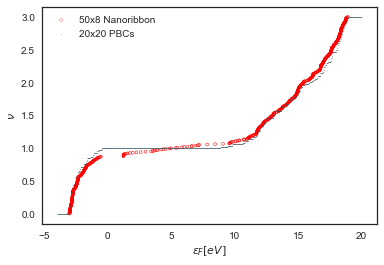

In [18]:
Nx = 50
Ny = 8

orbitalHoppingsNano = triangularNano(Nx, Ny, nOrb, hoppings)

ensMoS2nano = la.eigvalsh(orbitalHoppingsNano)
fig = plt.figure(0)
ax = fig.add_subplot(111)

ax.scatter(ensMoS2nano, np.arange(ensMoS2nano.size) / ensMoS2nano.size * 3, label='50x8 Nanoribbon'\
           , facecolors = 'none', edgecolors = 'r', s = 8)
plt.xlabel(r'$\varepsilon_F [ eV ]$')
plt.ylabel(r'$\nu$')
compareFill = np.loadtxt("filling-E_3orbModel_MoS2_noSOC_Units-t0.csv", delimiter=',')
ax.scatter(compareFill[:, 1], compareFill[:, 0] , s = 0.1, label='20x20 PBCs')
lgd = ax.legend(loc=2)
plt.savefig(SAVEDIR + "/fillingVsEnanoribbon.png", dpi = 600, bbox_inches='tight')

In [83]:
349 / ensMoS2nano.size

0.29083333333333333

In [86]:
0.42 / 2

0.21

In [87]:
3 * 0.2

0.6000000000000001